In [30]:
import numpy as np
import pandas as pd

# Récupération des data

In [ ]:
from wilds import get_dataset

# ETAPE 1 : Téléchargement et chargement automatiquement les données organisées
dataset = get_dataset(dataset="camelyon17", download=True)

You can also download the dataset manually at https://wilds.stanford.edu/downloads.


10658897920Byte [50:14, 3536210.42Byte/s]                                


Extracting data/camelyon17_v1.0/archive.tar.gz to data/camelyon17_v1.0


  5%|▌         | 575832064/10658709504 [1:23:34<24:23:23, 114835.01Byte/s]



It took 53.76 minutes to download and uncompress the dataset.



In [6]:
dataset = get_dataset("camelyon17", root_dir="data", download=False)

In [8]:
print(dataset)
print(dataset.split_dict)

{'train': 0, 'id_val': 1, 'test': 2, 'val': 3}


In [27]:
print(dataset._metadata_fields)

['hospital', 'slide', 'y', 'from_source_domain']


In [15]:
# ÉTAPE 2 : PRÉPARATION DES DONNÉES (SPLITS)
# Le dataset est déjà divisé par hôpitaux pour tester la robustesse (Domain Shift)
# Train = Hôpitaux 0, 1, 2
# Val   = Hôpital 3
# Test  = Hôpital 4

train_data = dataset.get_subset("train")
val_data = dataset.get_subset("val")
test_data = dataset.get_subset("test")
id_val_data = dataset.get_subset("id_val")

print(f"Nombre de patchs d'entraînement : {len(train_data)}")
print(f"Nombre de patchs de validation  : {len(val_data)}")
print(f"Nombre de patchs de test        : {len(test_data)}")
print(f"Nombre de patchs de id_val      : {len(id_val_data)}")

Nombre de patchs d'entraînement : 302436
Nombre de patchs de validation  : 34904
Nombre de patchs de test        : 85054
Nombre de patchs de id_val      : 33560


In [16]:
total_patch = len(train_data) + len(val_data) + len(test_data) + len(id_val_data)
print(total_patch)

455954


In [13]:
# ÉTAPE 4 : VISUALISATION D'UN EXEMPLE
# On prend la première image du set d'entraînement
# x = l'image, y = le label (cancer ou pas), metadata = info sur l'hôpital
x, y, metadata = train_data[0]

# Affichage des infos
hospital_id = metadata[0].item() # Le 1er élément des métadonnées est l'ID de l'hôpital
label_name = "Tumeur" if y.item() == 1 else "Sain"

print(f"\n--- Exemple de patch ---")
print(f"Label   : {y.item()} ({label_name})")
print(f"Hôpital : {hospital_id} (Centre n°{hospital_id})")
print(f"Taille  : {x.size}")


--- Exemple de patch ---
Label   : 1 (Tumeur)
Hôpital : 0 (Centre n°0)
Taille  : (96, 96)


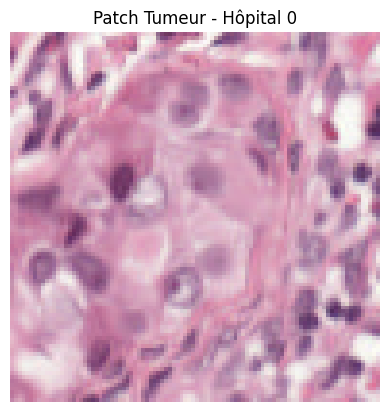

In [22]:
import matplotlib.pyplot as plt

# Affichage de l'image
plt.imshow(x)
plt.title(f"Patch {label_name} - Hôpital {hospital_id}")
plt.axis('off')
plt.show()

# EDA sur le df_train

In [37]:
meta = train_data.metadata_array
cols = dataset._metadata_fields
df_train = pd.DataFrame(meta.numpy(), columns=cols)

In [38]:
df_train.head()

,hospital,slide,y,from_source_domain
0,0,0,1,1
1,0,0,1,1
2,0,0,1,1
3,0,0,1,1
4,0,0,1,1


In [43]:
# Nombre de patches et ratio tumoraux
n_patches = len(df_train)
nb_tumor = (df_train["y"] == 1).sum()
ratio_tumor = nb_tumor / n_patches
print('Nb de patches:', n_patches)
print('Nb de tumeur:', nb_tumor)
print('Ratio de tumeur:', round(ratio_tumor, 3))

Nb de patches: 302436
Nb de tumeur: 151390
Ratio de tumeur: 0.501


In [45]:
# Nombre de patches par hopital
patches_par_h = df_train.groupby("hospital").size()
print(patches_par_h)

hospital
0     53425
3    116959
4    132052
dtype: int64


In [ ]:
# Nombre de tumeur par hopital et ratio
tumor_par_h = df_train.groupby("hospital")["y"].agg(
    nb_tumor="sum",
    nb_total="count"
)
tumor_par_h["ratio_tumor"] = round((tumor_par_h["nb_tumor"] / tumor_par_h["nb_total"]), 3)
print(tumor_par_h)

          nb_tumor  nb_total  ratio_tumor
hospital                                 
0            26739     53425        0.500
3            58523    116959        0.500
4            66128    132052        0.501


# EDA sur csv complet

In [71]:
df_csv = pd.read_csv('data/camelyon17_v1.0/metadata.csv')

In [72]:
df_csv

,Unnamed: 0,patient,node,x_coord,y_coord,tumor,slide,center,split
0,0,4,4,3328,21792,1,0,0,0
1,1,4,4,3200,22272,1,0,0,0
2,2,4,4,3168,22272,1,0,0,0
3,3,4,4,3328,21760,1,0,0,0
4,4,4,4,3232,22240,1,0,0,0
...,...,...,...,...,...,...,...,...,...
455949,455949,88,1,14784,7648,0,45,4,1
455950,455950,99,4,3872,11328,0,49,4,0
455951,455951,92,1,31968,9536,0,47,4,0
455952,455952,81,4,23712,12192,0,41,4,0


In [167]:
df_csv["tumor"].value_counts()

tumor
1    227977
0    227977
Name: count, dtype: int64

In [169]:
df_csv["center"].value_counts().sort_index()

center
0     59436
1     34904
2     85054
3    129838
4    146722
Name: count, dtype: int64

In [73]:
# Ajout des patches par ligne
patch_paths = [dataset._input_array[i] for i in df_csv.index]

In [74]:
# Test longueur patch_paths et dataset
assert len(patch_paths) == len(dataset)

In [75]:
# Ajout de la colonne des patch
patch_names = [p.split("/")[-1] for p in patch_paths]
df_csv["patch_path"] = patch_names

In [76]:
df_csv

,Unnamed: 0,patient,node,x_coord,y_coord,tumor,slide,center,split,patch_path
0,0,4,4,3328,21792,1,0,0,0,patch_patient_004_node_4_x_3328_y_21792.png
1,1,4,4,3200,22272,1,0,0,0,patch_patient_004_node_4_x_3200_y_22272.png
2,2,4,4,3168,22272,1,0,0,0,patch_patient_004_node_4_x_3168_y_22272.png
3,3,4,4,3328,21760,1,0,0,0,patch_patient_004_node_4_x_3328_y_21760.png
4,4,4,4,3232,22240,1,0,0,0,patch_patient_004_node_4_x_3232_y_22240.png
...,...,...,...,...,...,...,...,...,...,...
455949,455949,88,1,14784,7648,0,45,4,1,patch_patient_088_node_1_x_14784_y_7648.png
455950,455950,99,4,3872,11328,0,49,4,0,patch_patient_099_node_4_x_3872_y_11328.png
455951,455951,92,1,31968,9536,0,47,4,0,patch_patient_092_node_1_x_31968_y_9536.png
455952,455952,81,4,23712,12192,0,41,4,0,patch_patient_081_node_4_x_23712_y_12192.png


In [78]:
# Nombre de patches et ratio tumoraux
n_patches = len(df_csv)
nb_tumor = (df_csv["tumor"] == 1).sum()
ratio_tumor = nb_tumor / n_patches
print('Nb de patches:', n_patches)
print('Nb de tumeur:', nb_tumor)
print('Ratio de tumeur:', round(ratio_tumor, 3))

Nb de patches: 455954
Nb de tumeur: 227977
Ratio de tumeur: 0.5


In [81]:
# Nombre de patches par hopital
patches_par_c = df_csv.groupby("center").size()
print(patches_par_c)

center
0     59436
1     34904
2     85054
3    129838
4    146722
dtype: int64


# Feature Engineering

In [85]:
# Nombre de tumeur par hopital et ratio
tumor_par_c = df_csv.groupby("center")["tumor"].agg(
    nb_tumor="sum",
    nb_total="count"
)
tumor_par_c["ratio_tumor"] = round((tumor_par_c["nb_tumor"] / tumor_par_c["nb_total"]), 3)
print(tumor_par_c)

        nb_tumor  nb_total  ratio_tumor
center                                 
0          29718     59436          0.5
1          17452     34904          0.5
2          42527     85054          0.5
3          64919    129838          0.5
4          73361    146722          0.5


In [88]:
# Pour chaque patient : nb de patch et nb de patch tumoraux
patients = df_csv.groupby("patient")["tumor"].agg(
    nb_patches="count",
    nb_tumor="sum"
)
print(patients)

         nb_patches  nb_tumor
patient                      
4              4316        36
9              4597       307
10             4046      1192
12            13637     12649
15            10554      6063
16             3427         5
17            18859      9466
20             7449      3400
21             1705       157
22            10404      8776
24             3854        49
34             4971      4094
36             2659       629
38             1275       178
39             2587       169
40             3810        27
41             3694        10
42             7210      4229
44             5288      2761
45             7727       184
46             8149      1524
48             4556       110
51            31878     26998
52            12742      6684
60            10623        15
61             3466       123
62             8831      2178
64             4019        19
66             3950       169
67             6089       177
68            10661        16
72        

In [93]:
# Patient ayant une tumeur, au moins un patch avec tumor = 1
patients["has_tumor"] = (patients["nb_tumor"] > 0).astype(int)

# Calcul du ratio de patient atteint de tumeur
nb_patients = len(patients)
nb_patients_tumor = patients["has_tumor"].sum()
ratio_patient_tumor = nb_patients_tumor / nb_patients

print(ratio_patient_tumor)

1.0


In [97]:
# Patient par centre
patient_center = df_csv[["patient", "center"]].drop_duplicates()

# Join au df patients
patients = patients.merge(patient_center, on="patient", how="left")


In [98]:
patients

,patient,nb_patches,nb_tumor,has_tumor,center
0,4,4316,36,1,0
1,9,4597,307,1,0
2,10,4046,1192,1,0
3,12,13637,12649,1,0
4,15,10554,6063,1,0
5,16,3427,5,1,0
6,17,18859,9466,1,0
7,20,7449,3400,1,1
8,21,1705,157,1,1
9,22,10404,8776,1,1


In [ ]:
# Nombre de patient par centre
patients_par_center = patients.groupby("center")['has_tumor'].agg(
    nb_patients="count",
    nb_patients_tumor="sum"
)
patients_par_center["ratio_patients_tumor"] = (
    patients_par_center["nb_patients_tumor"] / patients_par_center["nb_patients"]
)

print(patients_par_center)

        nb_patients  nb_patients_tumor  ratio_patients_tumor
center                                                      
0                 7                  7                   1.0
1                 8                  8                   1.0
2                 9                  9                   1.0
3                10                 10                   1.0
4                 9                  9                   1.0


In [ ]:
# Calcul du % de patch tumoraux par patient
ratio_tumor_patch = patients["nb_tumor"] / patients["nb_patches"]
patients["percentage_tumor (%)"] = round(ratio_tumor_patch, 4) * 100

In [120]:
patients

,patient,nb_patches,nb_tumor,has_tumor,center,percentage_tumor (%)
0,4,4316,36,1,0,0.83
1,9,4597,307,1,0,6.68
2,10,4046,1192,1,0,29.46
3,12,13637,12649,1,0,92.76
4,15,10554,6063,1,0,57.45
5,16,3427,5,1,0,0.15
6,17,18859,9466,1,0,50.19
7,20,7449,3400,1,1,45.64
8,21,1705,157,1,1,9.21
9,22,10404,8776,1,1,84.35


In [131]:
# Calculer le % de patch par patient
ratio_patch_patient = patients["nb_patches"] / patients["nb_patches"].sum()
patients["pourcentage_patch (%)"] = round(ratio_patch_patient, 4) * 100

In [124]:
patients

,patient,nb_patches,nb_tumor,has_tumor,center,percentage_tumor (%),pourcentage_patch (%)
0,4,4316,36,1,0,0.83,0.95
1,9,4597,307,1,0,6.68,1.01
2,10,4046,1192,1,0,29.46,0.89
3,12,13637,12649,1,0,92.76,2.99
4,15,10554,6063,1,0,57.45,2.31
5,16,3427,5,1,0,0.15,0.75
6,17,18859,9466,1,0,50.19,4.14
7,20,7449,3400,1,1,45.64,1.63
8,21,1705,157,1,1,9.21,0.37
9,22,10404,8776,1,1,84.35,2.28


In [125]:
patients["nb_tumor"].describe()

count       43.000000
mean      5301.790698
std      11804.096463
min          5.000000
25%         61.000000
50%        184.000000
75%       5089.000000
max      56666.000000
Name: nb_tumor, dtype: float64

In [ ]:
# Fonction de définition de la sévérité de la tumeur
def sev_cat(r):
    if r == 0:
        return "0 - aucun patch tumoral"
    elif r < 0.1:
        return "1 - très peu de tumeur"
    elif r < 0.5:
        return "2 - modérée"
    else:
        return "3 - forte"

In [136]:
patients["sev_cat"] = (patients["percentage_tumor (%)"] / 100).apply(sev_cat)

In [137]:
patients

,patient,nb_patches,nb_tumor,has_tumor,center,percentage_tumor (%),pourcentage_patch (%),sev_cat
0,4,4316,36,1,0,0.83,0.95,1 - très peu de tumeur
1,9,4597,307,1,0,6.68,1.01,1 - très peu de tumeur
2,10,4046,1192,1,0,29.46,0.89,2 - modérée
3,12,13637,12649,1,0,92.76,2.99,3 - forte
4,15,10554,6063,1,0,57.45,2.31,3 - forte
5,16,3427,5,1,0,0.15,0.75,1 - très peu de tumeur
6,17,18859,9466,1,0,50.19,4.14,3 - forte
7,20,7449,3400,1,1,45.64,1.63,2 - modérée
8,21,1705,157,1,1,9.21,0.37,1 - très peu de tumeur
9,22,10404,8776,1,1,84.35,2.28,3 - forte


In [148]:
print(patients["sev_cat"].value_counts())

sev_cat
1 - très peu de tumeur    23
3 - forte                 13
2 - modérée                7
Name: count, dtype: int64


In [179]:
# Distribution de la sévérité par centre
sev_par_center = patients.groupby(["center", "sev_cat"])["sev_cat"].count()
sev_par_center

center  sev_cat               
0       1 - très peu de tumeur    3
        2 - modérée               1
        3 - forte                 3
1       1 - très peu de tumeur    3
        2 - modérée               3
        3 - forte                 2
2       1 - très peu de tumeur    4
        2 - modérée               1
        3 - forte                 4
3       1 - très peu de tumeur    7
        2 - modérée               1
        3 - forte                 2
4       1 - très peu de tumeur    6
        2 - modérée               1
        3 - forte                 2
Name: sev_cat, dtype: int64

In [181]:
sev_par_center = sev_par_center.groupby(level=0).apply(lambda s: s / s.sum())
sev_par_center

center  center  sev_cat               
0       0       1 - très peu de tumeur    0.428571
                2 - modérée               0.142857
                3 - forte                 0.428571
1       1       1 - très peu de tumeur    0.375000
                2 - modérée               0.375000
                3 - forte                 0.250000
2       2       1 - très peu de tumeur    0.444444
                2 - modérée               0.111111
                3 - forte                 0.444444
3       3       1 - très peu de tumeur    0.700000
                2 - modérée               0.100000
                3 - forte                 0.200000
4       4       1 - très peu de tumeur    0.666667
                2 - modérée               0.111111
                3 - forte                 0.222222
Name: sev_cat, dtype: float64